In [17]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from xgboost import XGBClassifier

In [2]:
import pathlib

dataset_url = "archive/Multi Cancer/data/Brain Cancer"
test_url = "archive/Multi Cancer/data/test"

data_dir = pathlib.Path(dataset_url).with_suffix('')
test_dir = pathlib.Path(test_url).with_suffix('')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count, test_count)

12750 2250


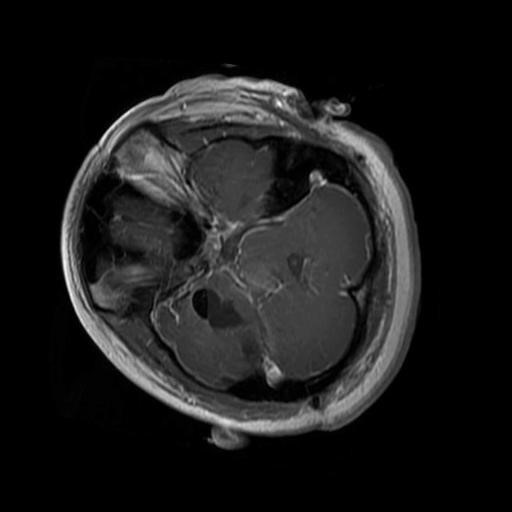

In [4]:
brain_glioma = list(data_dir.glob('brain_glioma/*'))
PIL.Image.open(str(brain_glioma[2]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 10200 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 2550 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2250 files belonging to 3 classes.


In [9]:
class_names = train_ds.class_names
class_names

['brain_glioma', 'brain_menin', 'brain_tumor']

0
1
2
3
4
5
6
7
8


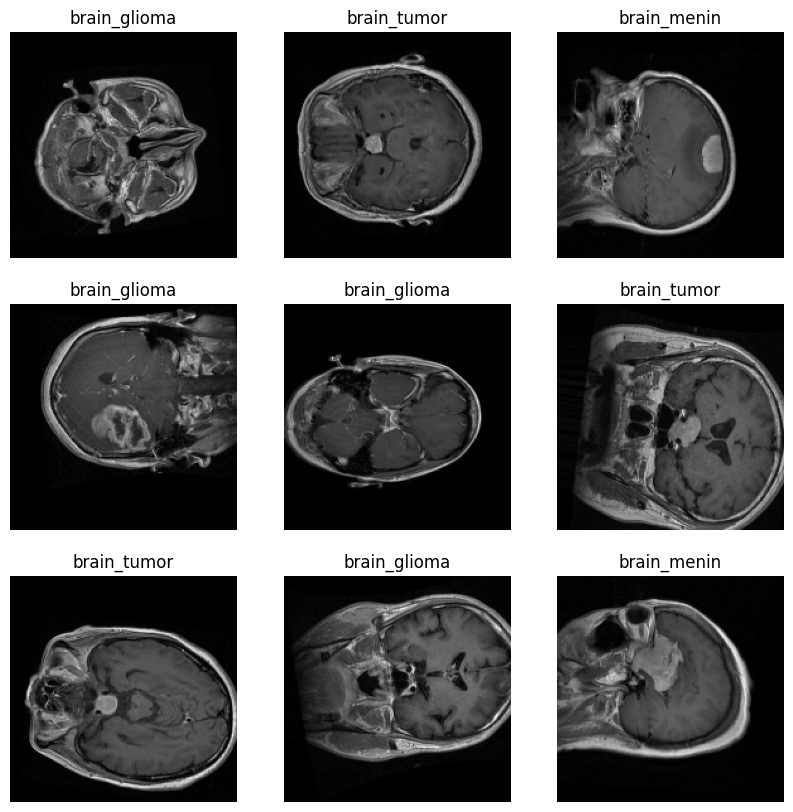

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(i)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name='feature_layer'), # give the layer a name so we can reference it later to get just the features before softmax
  layers.Dense(num_classes, activation='softmax') # even though XGB is going to be the classifier, this is required for now to train the model
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
epochs=50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
319/319 [==============================] - 4s 10ms/step - loss: 0.6800 - accuracy: 0.6991 - val_loss: 0.4921 - val_accuracy: 0.8047
Epoch 2/50
319/319 [==============================] - 3s 10ms/step - loss: 0.4256 - accuracy: 0.8284 - val_loss: 0.4184 - val_accuracy: 0.8443
Epoch 3/50
319/319 [==============================] - 3s 10ms/step - loss: 0.2798 - accuracy: 0.8930 - val_loss: 0.3653 - val_accuracy: 0.8600
Epoch 4/50
319/319 [==============================] - 3s 10ms/step - loss: 0.1673 - accuracy: 0.9377 - val_loss: 0.3857 - val_accuracy: 0.8588
Epoch 5/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0986 - accuracy: 0.9653 - val_loss: 0.4964 - val_accuracy: 0.8510
Epoch 6/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0.5931 - val_accuracy: 0.8604
Epoch 7/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.6097 - val_accuracy: 0.8592

In [25]:
# duplicate the existing model minus softmax layer
feature_extractor = models.Model(
    inputs=model.input,
    outputs=model.get_layer('feature_layer').output
)

In [26]:
def extract_features(dataset, extractor):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = extractor.predict(images, verbose=0)
        all_features.append(features)
        all_labels.append(labels.numpy()) # Convert labels tensor to numpy
    return np.concatenate(all_features), np.concatenate(all_labels)

# get the features from the training and validation sets
train_features, train_labels = extract_features(train_ds, feature_extractor)
val_features, val_labels = extract_features(val_ds, feature_extractor)

In [32]:
# train XGBClassifier
xgb_classifier = XGBClassifier(
    objective='multi:softmax',   # learning task: learning objective
    num_class=num_classes,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,     # recommended by API
    early_stopping_rounds=10,    
    eval_metric='mlogloss'       # just log loss but multi
)


In [33]:

# Train the XGBoost model using extracted features and labels
xgb_classifier.fit(
    train_features,
    train_labels,
    eval_set=[(val_features, val_labels)], # Use validation set for evaluation
)

[0]	validation_0-mlogloss:0.99313
[1]	validation_0-mlogloss:0.90606
[2]	validation_0-mlogloss:0.83283
[3]	validation_0-mlogloss:0.77074
[4]	validation_0-mlogloss:0.71832
[5]	validation_0-mlogloss:0.67364
[6]	validation_0-mlogloss:0.63363
[7]	validation_0-mlogloss:0.59935
[8]	validation_0-mlogloss:0.57009
[9]	validation_0-mlogloss:0.54436
[10]	validation_0-mlogloss:0.52276
[11]	validation_0-mlogloss:0.50385
[12]	validation_0-mlogloss:0.48721
[13]	validation_0-mlogloss:0.47239
[14]	validation_0-mlogloss:0.46072
[15]	validation_0-mlogloss:0.45052
[16]	validation_0-mlogloss:0.44142
[17]	validation_0-mlogloss:0.43342
[18]	validation_0-mlogloss:0.42730
[19]	validation_0-mlogloss:0.42164
[20]	validation_0-mlogloss:0.41730
[21]	validation_0-mlogloss:0.41375
[22]	validation_0-mlogloss:0.41172
[23]	validation_0-mlogloss:0.40983
[24]	validation_0-mlogloss:0.40874
[25]	validation_0-mlogloss:0.40807
[26]	validation_0-mlogloss:0.40823
[27]	validation_0-mlogloss:0.40874
[28]	validation_0-mlogloss:0.4

C:\Users\Sean Nolan\miniconda3\envs\ai\lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-mlogloss:0.41731
[33]	validation_0-mlogloss:0.41926
[34]	validation_0-mlogloss:0.42251
[35]	validation_0-mlogloss:0.42552


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [30]:
accuracy = xgb_classifier.score(val_features, val_labels)
print(f"XGBoost Validation Accuracy: {accuracy * 100:.2f}%")

XGBoost Validation Accuracy: 86.47%


In [37]:
y_pred_xgb = []
y_true = []

for image_batch, label_batch in test_ds:
   features_batch = feature_extractor.predict(image_batch, verbose=0)
   preds = xgb_classifier.predict(features_batch)
    
   y_true.append(label_batch.numpy())
   y_pred_xgb.append(preds)

correct_labels = np.concatenate(y_true, axis=0)
predicted_labels_xgb = np.concatenate(y_pred_xgb, axis=0)


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_xgb = accuracy_score(correct_labels, predicted_labels_xgb)
print(f"\nXGBoost Test Accuracy: {accuracy_xgb * 100:.2f}%")

print("\nXGBoost Confusion Matrix:")
cm = confusion_matrix(correct_labels, predicted_labels_xgb)
print(cm)


XGBoost Test Accuracy: 85.78%

XGBoost Confusion Matrix:
[[650  88  12]
 [ 53 598  99]
 [ 11  57 682]]
